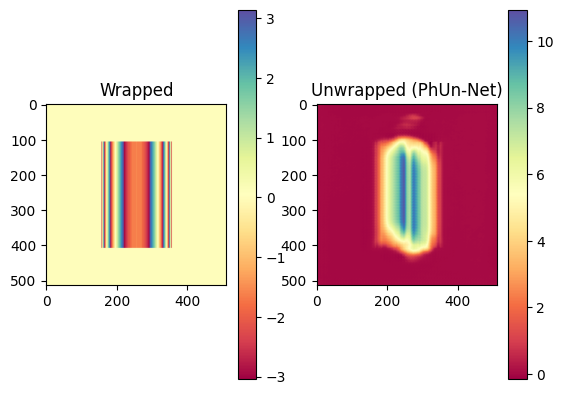

Input_input [1, 1, 512, 512] tensor(float)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import onnxruntime as ort
import sys, os
sys.path.append(os.path.abspath("../src"))

# Grid (µm/px)
Nx, Ny = 512, 512
px, py = 0.2, 0.2

# Optics
lam   = 0.532     # wavelength (µm)
n_med = 1.33      # medium index
pz    = 0.2       # z step for integration (µm)  

# Material: either a scalar, a 2D array n(x,y), or a callable n_obj(X,Y,z)
n_obj = 1.38      

# Activate for cylinder geometry

R = 20.0          # radius (µm)
L = 60.0          # axis length along x (µm); set None for infinite

from cylinder_phase import cylinder_phase_perp_to_z_3d

session = ort.InferenceSession(r"C:\Users\ofirh\odt-thesis\src\PhUnNet.onnx")

# Example: load a wrapped phase image
# Replace with one of your simulated wrapped phases
phi_true, phi_wrapped, tissue_mask, medium_mask  = cylinder_phase_perp_to_z_3d(
    Nx, Ny, px, py,
    R, L,
    lam=lam, n_med=n_med,
    n_obj=n_obj,
    pz=pz
)

wrapped = phi_wrapped

# --- Preprocess ---
# (1) Normalize: PhUn-Net expects input scaled to [-π, π] or [0,1].
# Check the paper, but try scaling to [-π, π] first:
wrapped = (wrapped / np.max(np.abs(wrapped))) * np.pi  

# (2) Add batch & channel dimensions → shape (1,1,H,W)
input_tensor = np.expand_dims(wrapped, axis=(0,1))

wrapped = wrapped.astype(np.float32)
input_tensor = np.expand_dims(wrapped, axis=(0,1)).astype(np.float32)

# Run inference
outputs = session.run(None, {"Input_input": input_tensor})
unwrapped = outputs[0][0,0,:,:]  # (H,W)

# --- Plot ---

plt.subplot(1,2,1)
plt.title("Wrapped")
plt.imshow(wrapped, cmap="Spectral"); plt.colorbar()

plt.subplot(1,2,2)
plt.title("Unwrapped (PhUn-Net)")
plt.imshow(unwrapped, cmap="Spectral"); plt.colorbar()
plt.show()


for inp in session.get_inputs():
    print(inp.name, inp.shape, inp.type)